In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

# Import TDA pipeline requirements
import gudhi as gd
import json

from scipy import ndimage, interpolate

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [4]:
maximgsize = 1250
mintransnum = 5
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
ksrc = '../kde/'
csrc = '../data/'
dst = '../gd_trans/'
figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

sample = 'D2'

ksrc += sample + os.sep
dst = dst + sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = sorted([foo.split('/')[-2] for foo in glob(ksrc + '*/')])
print(len(transcriptomes), 'transcriptomes')

97 transcriptomes


In [5]:
wallshape = (np.max(metacell['x1']), np.max(metacell['x1']))
wallshape

(17152, 17152)

In [214]:
tidx = 26
print('Analyze',transcriptomes[tidx])
sdst = dst + transcriptomes[tidx] + os.sep
if not os.path.isdir(sdst):
    os.mkdir(sdst)

kdefiles = glob(ksrc + transcriptomes[tidx] + os.sep + '*.npy')
ratios = transcell.iloc[tidx, :-1].values.astype(float) / metatrans.loc[tidx, 'cyto_number']
#transnum = transcell.iloc[tidx, :-1].values.astype(float)
#ratios = transnum[transnum > mintransnum]/np.sum(transnum[transnum > mintransnum])

metakde = np.zeros((len(kdefiles), 4), dtype=int)
rawkdemax = np.zeros(len(metakde))
for i in range(len(kdefiles)):
    foo = (os.path.splitext(os.path.split(kdefiles[i])[1])[0]).split('_')
    for j in range(metakde.shape[1]):
        metakde[i,j] = int(foo[j][1:])
    rawkdemax[i] = float(foo[-1][1:])
metakde = pd.DataFrame(metakde, columns=['ndimage_cellID', 'pad', 'stepsize', 'bandwidth'])
metakde['rawkdemax'] = rawkdemax
metakde['transnum'] = transcell.iloc[tidx, metakde['ndimage_cellID'].values].values.astype(int)
metakde['ratio_all'] = ratios[metakde['ndimage_cellID'].values]
metakde['ratio_select'] = metakde['transnum']/np.sum(metakde['transnum'])
metakde['kdemax_all'] = metakde['rawkdemax']*metakde['ratio_all']
metakde['kdemax_select'] = metakde['rawkdemax']*metakde['ratio_select']
metakde = metakde[metakde['ndimage_cellID'] != 0]

print(metakde.shape)
metakde.head(10)
metakde.sort_values(by='kdemax_all', ascending=False).head(10)

Analyze GLYMA_05G092200
(2870, 10)


,ndimage_cellID,pad,stepsize,bandwidth,rawkdemax,transnum,ratio_all,ratio_select,kdemax_all,kdemax_select
163,295,6,5,15,0.000064,760,0.000994,0.001000,6.386209e-08,6.425500e-08
826,570,6,5,15,0.000064,768,0.001004,0.001010,6.384658e-08,6.423940e-08
532,286,6,5,15,0.000067,721,0.000943,0.000948,6.294515e-08,6.333242e-08
898,2169,6,5,15,0.000079,588,0.000769,0.000774,6.070519e-08,6.107868e-08
1765,2366,6,5,15,0.000050,913,0.001194,0.001201,5.972765e-08,6.009513e-08
1962,2149,6,5,15,0.000041,1121,0.001466,0.001475,5.957800e-08,5.994456e-08
927,418,6,5,15,0.000116,382,0.000499,0.000503,5.771987e-08,5.807500e-08
99,1599,6,5,15,0.000043,1020,0.001334,0.001342,5.746378e-08,5.781733e-08
1531,2151,6,5,15,0.000042,1023,0.001338,0.001346,5.651043e-08,5.685812e-08
1453,341,6,5,15,0.000089,482,0.000630,0.000634,5.631808e-08,5.666458e-08


In [253]:
selection = 'all'
vmax = np.max(metakde['kdemax_' + selection])
bins = np.linspace(0, vmax, 256)

idx = metakde[metakde['ndimage_cellID'] == 286].index[0]

jsname = '_'.join(np.asarray(os.path.splitext(os.path.split(kdefiles[idx])[1])[0].split('_'))[[0,3]])
cidx = metakde.loc[idx,'ndimage_cellID']

print(kdefiles[idx])

kde = np.load(kdefiles[idx], allow_pickle=True)*metakde.loc[idx, 'ratio_' + selection]

../kde/D2/GLYMA_05G092200/c286_p6_s5_b15_m6.6773100896174911568839438E-05.npy


In [254]:
PP = metakde.loc[idx, 'pad']
stepsize = metakde.loc[idx, 'stepsize']
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wallshape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wallshape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cy = ss[0].stop - ss[0].start
cx = ss[1].stop - ss[1].start
xaxis = np.arange(0, cx, stepsize); yaxis = np.arange(0, cy, stepsize)
xaxis += ss[1].start; yaxis += ss[0].start

In [255]:
cp = cartesian_product(np.arange(yaxis[0],yaxis[-1]), np.arange(xaxis[0],xaxis[-1]))
interp = interpolate.RegularGridInterpolator((yaxis, xaxis), kde, method='linear', bounds_error=True, fill_value=None)
img = interp(cp)
img = np.digitize(img, bins, right=True).astype(np.uint8).reshape(yaxis[-1]-yaxis[0],xaxis[-1]-xaxis[0])
img = np.pad(img, 5)

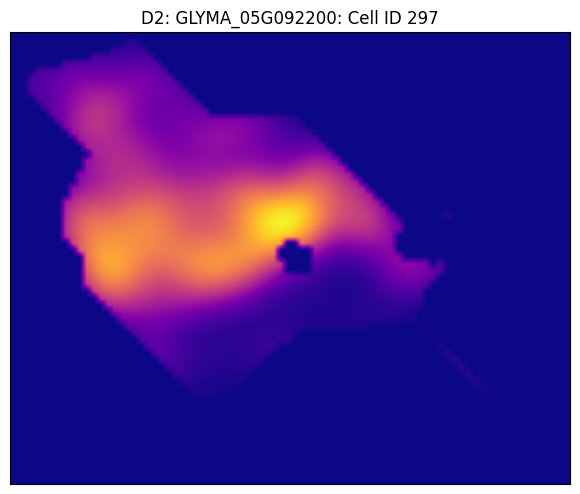

In [256]:
fs = 15
fig, ax = plt.subplots(1,1,figsize=(6,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

#ax[0].contourf(xaxis, yaxis, kde, 16, cmap='plasma')
ax[i].imshow(img, cmap='plasma', origin='lower', extent=extent, vmin=0, vmax=255)

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
title = '{}: {}: Cell ID {}'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'])
ax[0].set_title(title)
fig.tight_layout();

filename = figdst + '{}_{}_{}_{}_plain_kde'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'], cidx)
plt.savefig(filename + '.jpg', format='jpg', dpi=150, bbox_inches='tight', pil_kwargs={'optimize':True})

# Match cells

In [257]:
if max(img.shape) > maximgsize:
    zoom = maximgsize/max(img.shape)
    print(kdefiles[idx], '\nResized', img.shape, 'by a factor of ', zoom)
    img = ndimage.zoom(img, zoom = zoom, order=1, mode='reflect')
    print('Now', img.shape, '\n----')

In [258]:
cc = gd.CubicalComplex(top_dimensional_cells = img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
filename = sdst + transcriptomes[tidx] + '_' + jsname + '_' + selection + '_sublevel.json'
with open(filename, 'w') as f:
    json.dump(pers,f)
pers

[(1, (0.0, 252.0)),
 (1, (173.0, 203.0)),
 (1, (2.0, 15.0)),
 (1, (0.0, 10.0)),
 (1, (101.0, 110.0)),
 (1, (7.0, 13.0)),
 (1, (7.0, 13.0)),
 (1, (67.0, 72.0)),
 (1, (6.0, 10.0)),
 (1, (6.0, 10.0)),
 (1, (16.0, 19.0)),
 (1, (4.0, 6.0)),
 (1, (189.0, 191.0)),
 (1, (69.0, 71.0)),
 (1, (4.0, 6.0)),
 (1, (2.0, 4.0)),
 (0, (0.0, inf)),
 (0, (0.0, 24.0))]

In [259]:
bd = np.zeros((len(pers), 3), dtype=float)
for i in range(len(bd)):
    bd[i, 0] = pers[i][0]
    bd[i, 1:] = pers[i][1]
bd[ bd == np.inf] = 255

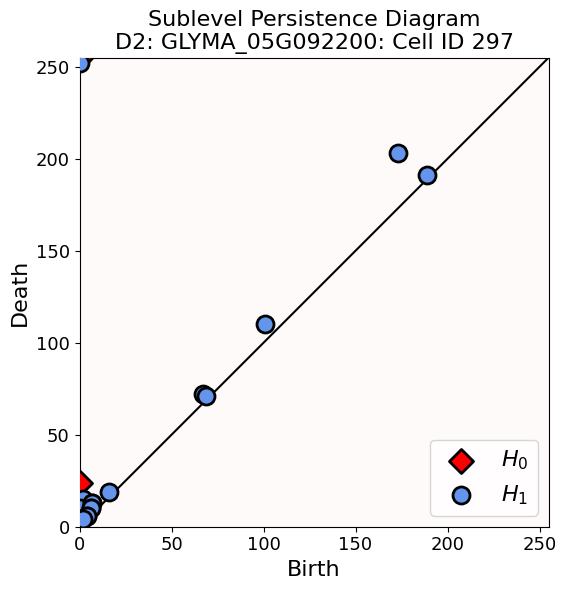

In [260]:
fs = 16; marker = ['D', 'o']; color = ['red','cornflowerblue']
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(2):
    mask = bd[:,0] == i
    ax[0].scatter(bd[mask, 1], bd[mask, 2], label='$H_{}$'.format(i), marker=marker[i], c=color[i], s=150, linewidth=2, edgecolor='k', zorder=i+4)

ax[0].scatter([0, np.max(bd)] , [np.max(bd), np.max(bd)] , alpha=0)
ax[0].legend(loc='lower right', fontsize=fs)
ax[0].set_aspect(1)
ax[0].axline(xy1=(0,0), slope=1, c='k', zorder=1)
ax[0].tick_params(labelsize=fs-3)
ax[0].set_xlabel('Birth', fontsize=fs)
ax[0].set_ylabel('Death', fontsize=fs)
ax[0].margins(0)
ax[0].set_facecolor('snow')

title = 'Sublevel Persistence Diagram\n{}: {}: Cell ID {}'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'])
ax[0].set_title(title, fontsize=fs)

fig.tight_layout()

filename = figdst + '{}_{}_{}_{}_sublevel_persistence_diagram'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'], cidx)
plt.savefig(filename + '.svg', format='svg', bbox_inches='tight')

In [261]:
morse = []
for i in range(len(pers)):
    for j in range(2):
        val = pers[i][1][j]
        if val < 300:
            morse.append(int(val))
morse.append(255)
morse = sorted(list(set(morse)))
print(len(morse), morse, sep='\n')

23
[0, 2, 4, 6, 7, 10, 13, 15, 16, 19, 24, 67, 69, 71, 72, 101, 110, 173, 189, 191, 203, 252, 255]


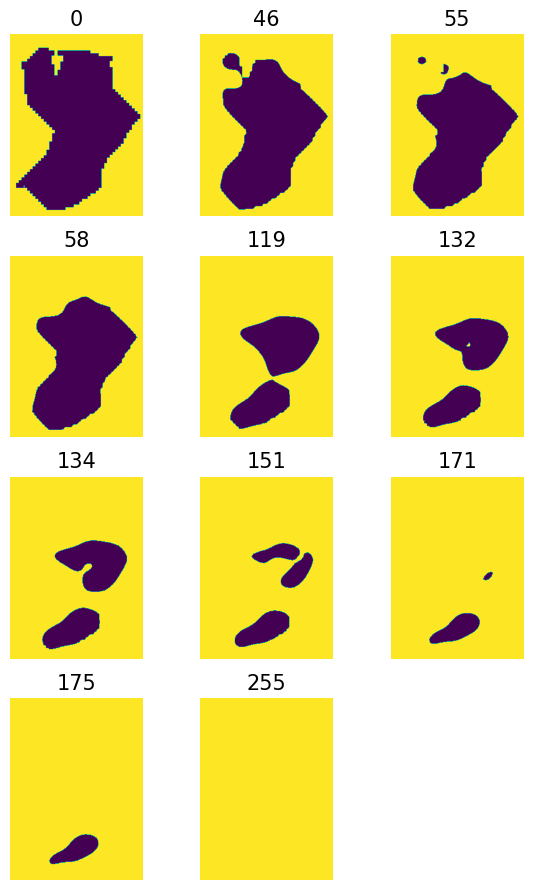

In [243]:
fig, ax = plt.subplots(4,3, figsize=(6,9), sharex=True, sharey=True)
ax = ax.ravel()

for i,val in enumerate(morse[:len(ax)]):
    ax[i].imshow(img <= val, vmin=0, vmax=1, origin='lower');
    ax[i].set_title(val, fontsize=15)
    ax[i].axis('off');
    
if len(ax) - len(morse) > 0:
    for i in range(len(ax) - len(morse)):
        fig.delaxes(ax[-i-1])

filename = figdst + '{}_{}_{}_{}_sublevel_sets'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'], cidx)
plt.savefig(filename + '.jpg', format='jpg', dpi=250, bbox_inches='tight', pil_kwargs={'optimize':True})
fig.tight_layout();

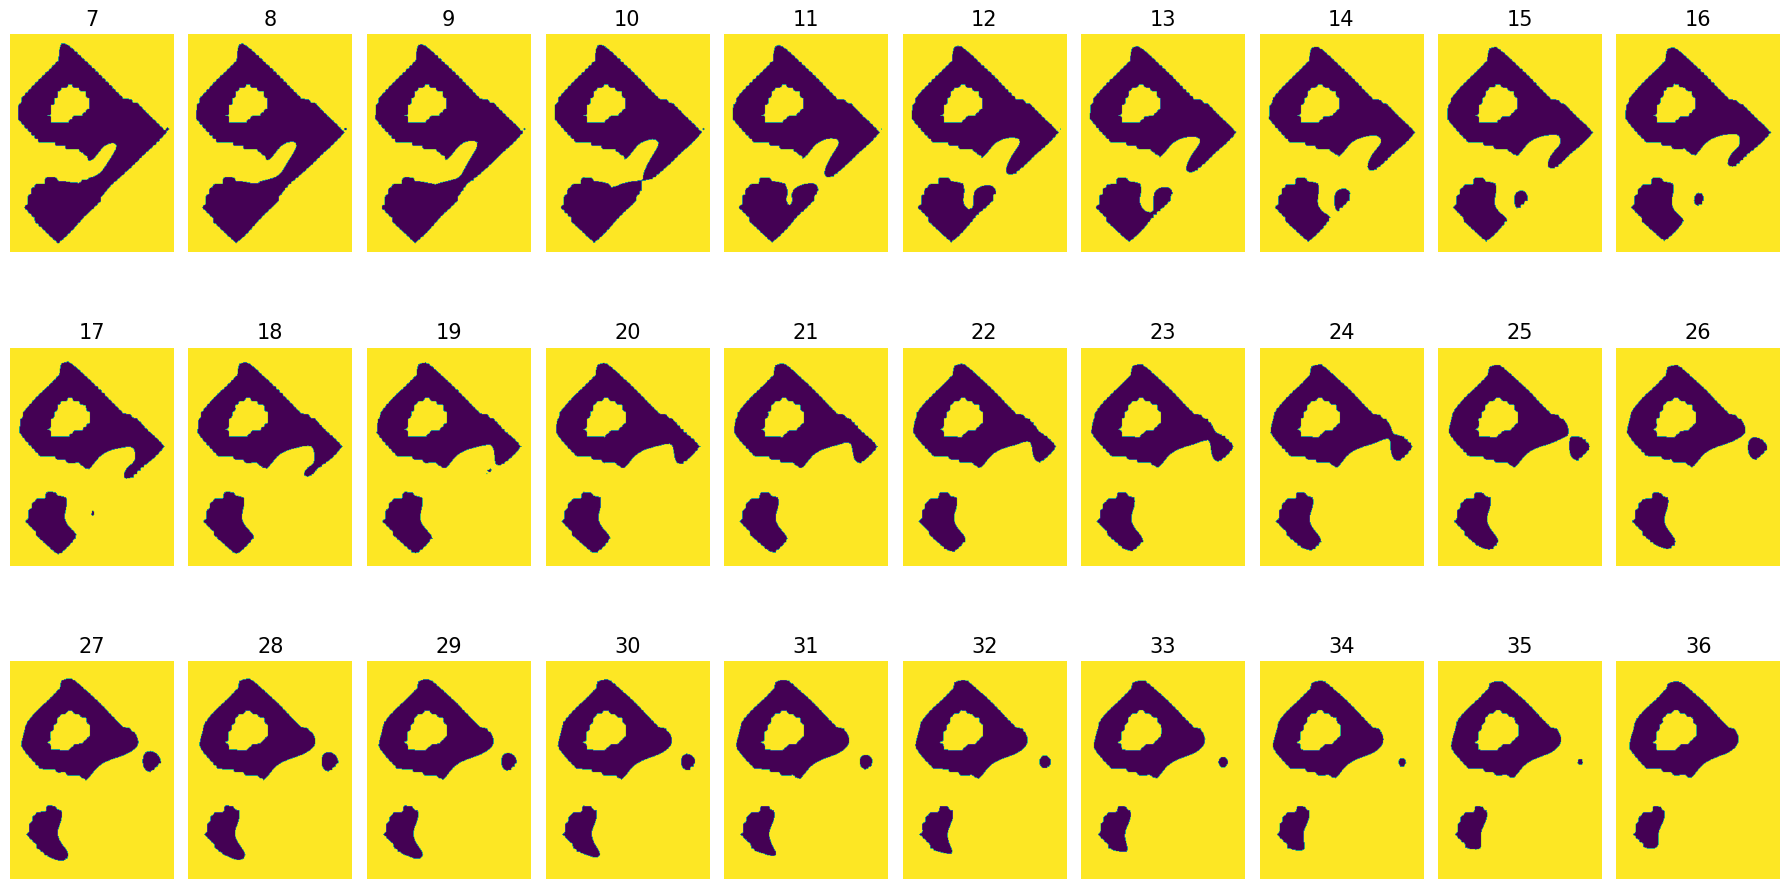

In [44]:
fig, ax = plt.subplots(3,10, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 7

for i in range(len(ax)):
    ax[i].imshow(img <= k + i, vmin=0, vmax=1, origin='lower');
    ax[i].set_title(k + i, fontsize=15)
    ax[i].axis('off');

fig.tight_layout();

In [23]:
maxv = img.max()
cc = gd.CubicalComplex(top_dimensional_cells = maxv-img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
filename = sdst + transcriptomes[tidx] + '_' + jsname + '_' + selection + '_superlevel.json'
print(filename)
with open(filename, 'w') as f:
    json.dump(pers,f)
pers

../gd_trans/D2/GLYMA_06G090100/GLYMA_06G090100_c2499_b15_all_superlevel.json


[(0, (0.0, inf)),
 (0, (49.0, 135.0)),
 (0, (50.0, 135.0)),
 (0, (62.0, 134.0)),
 (0, (71.0, 120.0)),
 (0, (85.0, 129.0)),
 (0, (84.0, 96.0)),
 (0, (32.0, 37.0))]

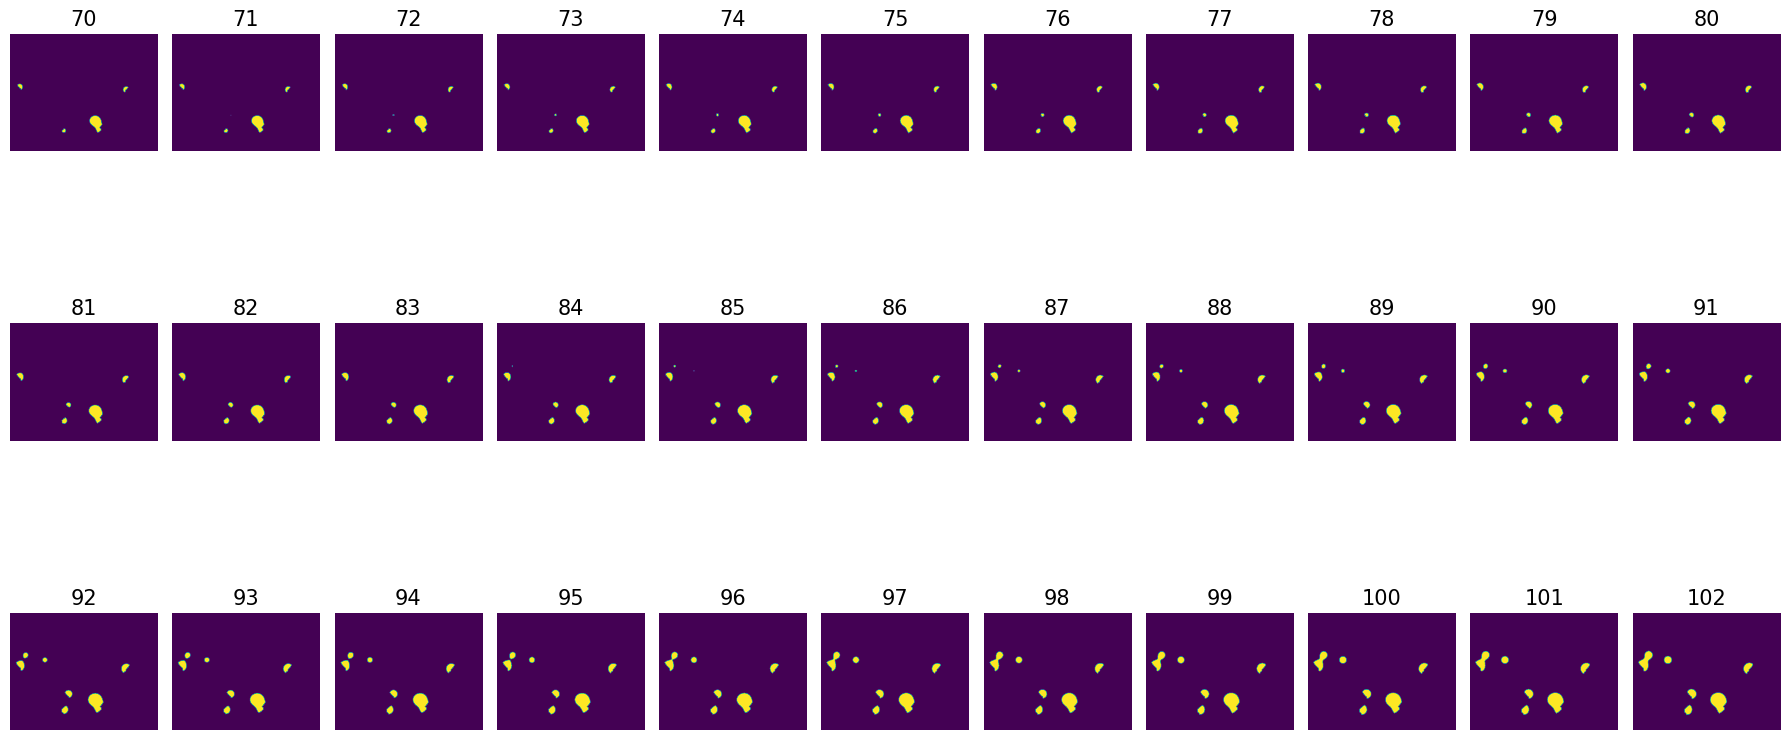

In [24]:
fig, ax = plt.subplots(3,11, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 70
bar = maxv - img 
for i in range(len(ax)):
    #j = len(ax) - 1 - i
    j = i
    ax[j].imshow(bar <= k + i, vmin=0, vmax=1, origin='lower');
    ax[j].set_title(k + i, fontsize=15)
    ax[j].axis('off');

fig.tight_layout();